In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shutil

In [24]:
data = pd.read_csv("/Users/farhat/Documents/Project/ProcessedData/fullData.csv")

# Training data and Label data split
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

#Train test split
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, Y,                 # Features and labels
                                                    test_size=0.2,        # 20% for testing
                                                    random_state=42,      # Ensures reproducibility
                                                    stratify=Y            # (Optional) maintains label proportions
)

In [ ]:
# Storing the test labels in different directory
# Combine X_test and y_test into one DataFrame

combined = X_test.copy()
combined['label'] = y_test.values  # Make sure index alignment is preserved

# Create output folder if not exists
output_dir = "/Users/farhat/Documents/Project/ProcessedData/LabelDirectory"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Group by patient_id and save each group as a separate .psv file
for patient_id, group in combined.groupby('Patient_Id'):
    # Only save the label column (or keep other columns if needed)
    patient_labels = group[['label']].rename(columns={'label': 'SepsisLabel'})
    
    # Build file path
    filename = f"{patient_id}.psv"
    filepath = os.path.join(output_dir, filename)
    
    # Save to .psv (pipe-separated)
    patient_labels.to_csv(filepath, sep='|', index=False)


Exception ignored in: <function ResourceTracker.__del__ at 0x1132c5bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


In [ ]:
# Hyper paramters selection and tunning using grid search CV
# XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 12, 15],
    'learning_rate': [0.05, 0.1, 0.12, 0.15],
    'n_estimators': [ 200, 400, 600, 650, 700]
}

# GridSearch with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train.iloc[:,1:], y_train)

# Storing the result in a dataframe

results = pd.DataFrame(grid_search.cv_results_)
results['cv'] = grid_search.cv
results_source = 'Results.csv'
if os.path.exists('Results.csv'):
    df = pd.read_csv('Results.csv')
    results = pd.concat([df, results], ignore_index=True)
else:
    results.to_csv('Results.csv')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:58:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:58:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

In [27]:
best_param = grid_search.best_params_
testing_best_param = pd.DataFrame([best_param])
testing_best_param['cv']=grid_search.cv
testing_best_param

,learning_rate,max_depth,n_estimators,cv
0,0.15,12,700,5


In [28]:
# Best model estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict_proba(X_test.iloc[:,1:])

In [29]:
# Accuracy Score
y_pred = y_pred[:,1] # Probability of 1
y_pred_binary = (y_pred >=0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
testing_best_param['accuracy']=accuracy
print(f"Tuned Model Accuracy: {accuracy:.4f}")

Tuned Model Accuracy: 0.9961


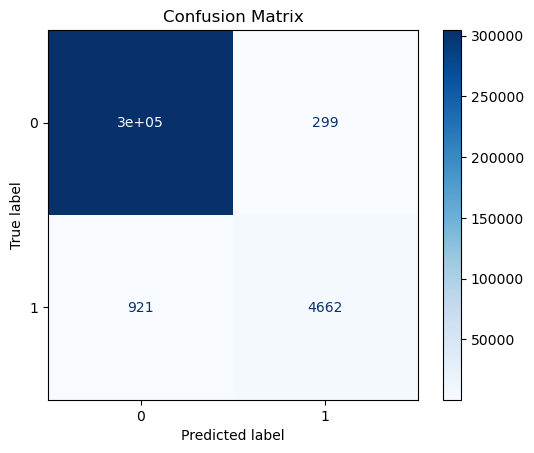

In [30]:
cm =confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')  # You can change the color map
testing_best_param['TN']=cm[0,0]
testing_best_param['FP']=cm[0,1]
testing_best_param['FN']=cm[1,0]
testing_best_param['TP']=cm[1,1]
plt.title("Confusion Matrix")
plt.show()


In [31]:
# Add predicted probabilities
combined['PredictedProbability'] = y_pred

# Add predicted labels based on threshold 0.5
combined['PredictedLabel'] = (combined['PredictedProbability'] >= 0.5).astype(int)


In [ ]:
# Ensure patient_id is present



if 'Patient_Id' not in combined.columns:
    raise ValueError("The column 'patient_id' must be present in X_test.")

# Create output folder
output_dir = "/Users/farhat/Documents/Project/ProcessedData/PredictionDirectory"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

# Group by patient_id and write predictions
for patient_id, group in combined.groupby('Patient_Id'):
    # Keep only necessary columns
    patient_predictions = group[['PredictedLabel', 'PredictedProbability']]

    # Create file path
    filename = f"{patient_id}.psv"
    filepath = os.path.join(output_dir, filename)

    # Save to .psv
    patient_predictions.to_csv(filepath, sep='|', index=False)


In [ ]:
from evaluate_sepsis_score import evaluate_sepsis_score #Importing the utility score function from the file provided by the challenge organizers

auroc, auprc, accuracy, f_measure, utility = evaluate_sepsis_score(label_directory, prediction_directory)
testing_best_param[['auroc','auprc', 'accuracy', 'f_measure', 'utility']] = [auroc, auprc, accuracy, f_measure, utility]
if os.path.exists('testing_best_param.csv'):
    test_df = pd.read_csv('testing_best_param.csv')
    testing_best_param = pd.concat([test_df, testing_best_param], axis=0)   
else:
    testing_best_param.to_csv('testing_best_param.csv')

Exception ignored in: <function ResourceTracker.__del__ at 0x105709bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107df9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110a6dbc0>
Traceback (most recent call last